## Setup

In [1]:
%matplotlib inline

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [5]:
import os
import shutil
import glob

## Arguments & Initializations

In [6]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [8]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [9]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [47]:
DATASET = "law_gender_aif"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia1"

In [48]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [49]:
ATTACK

'mia1'

## Loading & Splitting Dataset

In [50]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [51]:
dataset_orig.features.shape

(22342, 4)

In [52]:
privileged_groups

[{'gender': 1}]

In [53]:
sens_attr

'gender'

In [54]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [55]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

[[1.         1.         1.         0.975     ]
 [1.         1.         0.75675676 0.95      ]
 [1.         0.         0.67567568 0.9       ]
 ...
 [1.         0.         0.67567568 0.875     ]
 [1.         1.         0.86486486 0.975     ]
 [1.         0.         0.83783784 0.875     ]]
no bias type specified


## Run Mitigating Algorithms

### Setup for MIA2

In [56]:
seed = 1234
np.random.seed(seed)

In [57]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [58]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [59]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [60]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [61]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [62]:
target_dataset = None
reference_dataset = None

In [63]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

#### Train dataset's features are as below:
[[1.         0.         0.86486486 0.825     ]
 [1.         0.         0.64864865 0.9       ]
 [1.         0.         0.81081081 0.75      ]
 ...
 [1.         0.         0.86486486 0.9       ]
 [1.         0.         0.78378378 0.75      ]
 [1.         1.         0.59459459 0.85      ]]
no bias type specified
#### Training Dataset shape
(11171, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1}] [{'gender': 0}]
#### Privileged and unprivileged protected attribute values
[array([1.])] [array([0.])]
#### Dataset feature names
['race', 'gender', 'lsat', 'ugpa']
privileged vs. unprivileged:  6309.0 4862.0
base_pos unpriv:  0.2914438502673797
base_pos priv:  0.3067047075606277
number of favorable labels:  3352
Difference in mean outcomes between unprivileged and privileged groups = -0.015261
#### Train shape, validation shape, test shape
(11171

RUN DIRMITIGATOR
[INFO]: training decision tree
Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3445
Number of test samples (ntest): 3475
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1417
Number of test samples (ntest): 1381
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4374
Number of test samples (ntest): 4330
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1935
Number of test samples (ntest): 1985
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7819
         1.0       0.64      0.14      0.23      3352

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7185569778891774
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Orig

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3445
Number of test samples (ntest): 3475
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1417
Number of test samples (ntest): 1381
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4374
Number of test samples (ntest): 4330
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1935
Number of test samples (ntest): 1985
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7819
         1.0       0.58      0.15      0.23      3352

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7118431653388237
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.02
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -1.505774340303506
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7819, Test = 7805
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.06
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.010738730963293974
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3352, Test = 3366
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.87
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -1.505774340303506
)
MIA_Result(
  Name: subpopulation_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1382
Number of test samples (ntest): 1416
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4386
Number of test samples (ntest): 4318
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1955
Number of test samples (ntest): 1965
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7834
         1.0       0.65      0.13      0.22      3337

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.52     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7190940828932056
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.33
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7834, Test = 7790
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: -0.5596157879354228
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3337, Test = 3381
  AUC: 0.54
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.12
  Positive predictive value: 0.56
  Optimal thershold: -1.5260563034950494
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1382
Number of test samples (ntest): 1416
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4386
Number of test samples (ntest): 4318
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1955
Number of test samples (ntest): 1965
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7834
         1.0       0.57      0.14      0.23      3337

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7115746128368096
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7834, Test = 7790
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3337, Test = 3381
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.24
  Test Accuracy (TNR): 0.80
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -2.1383784091420277
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3437
Number of test samples (ntest): 3483
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1377
Number of test samples (ntest): 1421
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4383
Number of test samples (ntest): 4321
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1974
Number of test samples (ntest): 1946
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7820
         1.0       0.65      0.14      0.23      3351

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.7195416703965626
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.23
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -1.2367626271489267
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7820, Test = 7804
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.5389965007326871
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3351, Test = 3367
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.10
  Positive predictive value: 0.62
  Optimal thershold: -1.2367626271489267
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3437
Number of test samples (ntest): 3483
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1377
Number of test samples (ntest): 1421
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4383
Number of test samples (ntest): 4321
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1974
Number of test samples (ntest): 1946
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7820
         1.0       0.57      0.16      0.25      3351

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7121117178408379
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.02
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.01178425015858181
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7820, Test = 7804
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.01178425015858181
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3351, Test = 3367
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -1.2259660299134414
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3461
Number of test samples (ntest): 3459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1371
Number of test samples (ntest): 1427
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4362
Number of test samples (ntest): 4342
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1977
Number of test samples (ntest): 1943
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7823
         1.0       0.64      0.14      0.22      3348

    accuracy                           0.72     11171
   macro avg       0.68      0.55      0.53     11171
weighted avg       0.70      0.72      0.65     11171

Train accuracy:  0.718467460388506
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the D

Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: -0.8754687373538999
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7823, Test = 7801
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: -0.4462871026284195
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3348, Test = 3370
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.09
  Positive predictive value: 0.59
  Optimal thershold: -1.213022639845854
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3461
Number of test samples (ntest): 3459
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1371
Number of test samples (ntest): 1427
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4362
Number of test samples (ntest): 4342
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1977
Number of test samples (ntest): 1943
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7823
         1.0       0.60      0.13      0.21      3348

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.69      0.71      0.64     11171

Train accuracy:  0.7133649628502372
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -2.2005122411852853
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7823, Test = 7801
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3348, Test = 3370
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.17
  Test Accuracy (TNR): 0.88
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: -2.2005122411852853
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3430
Number of test samples (ntest): 3490
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1438
Number of test samples (ntest): 1360
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4343
Number of test samples (ntest): 4361
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1960
Number of test samples (ntest): 1960
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7773
         1.0       0.61      0.17      0.27      3398

    accuracy                           0.71     11171
   macro avg       0.67      0.56      0.54     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7146182078596366
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset

Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -1.041453874828161
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7773, Test = 7851
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.5899629443247145
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3398, Test = 3320
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.13
  Positive predictive value: 0.69
  Optimal thershold: -1.041453874828161
)
MIA_Result(
  N

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3430
Number of test samples (ntest): 3490
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1438
Number of test samples (ntest): 1360
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4343
Number of test samples (ntest): 4361
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1960
Number of test samples (ntest): 1960
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.94      0.82      7773
         1.0       0.58      0.18      0.28      3398

    accuracy                           0.71     11171
   macro avg       0.65      0.56      0.55     11171
weighted avg       0.68      0.71      0.66     11171

Train accuracy:  0.7119326828394951
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7773, Test = 7851
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3398, Test = 3320
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.04
  Positive predictive value: 0.57
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: subpo

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3472
Number of test samples (ntest): 3448
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1405
Number of test samples (ntest): 1393
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4331
Number of test samples (ntest): 4373
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1963
Number of test samples (ntest): 1957
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7803
         1.0       0.68      0.13      0.21      3368

    accuracy                           0.72     11171
   macro avg       0.70      0.55      0.52     11171
weighted avg       0.71      0.72      0.64     11171

Train accuracy:  0.7185569778891774
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset

Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -1.004202604197035
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7803, Test = 7821
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -0.5911822539032572
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3368, Test = 3350
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.10
  Positive predictive value: 0.56
  Optimal thershold: -1.415281897993143
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3472
Number of test samples (ntest): 3448
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1405
Number of test samples (ntest): 1393
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4331
Number of test samples (ntest): 4373
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1963
Number of test samples (ntest): 1957
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.82      7803
         1.0       0.60      0.16      0.26      3368

    accuracy                           0.71     11171
   macro avg       0.66      0.56      0.54     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7143496553576224
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.22613146080768315
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7803, Test = 7821
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3368, Test = 3350
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.21
  Test Accuracy (TNR): 0.84
  Attacker advantage: 0.05
  Positive predictive value: 0.58
  Optimal thershold: -0.9711560936566841
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3452
Number of test samples (ntest): 3468
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1377
Number of test samples (ntest): 1421
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4353
Number of test samples (ntest): 4351
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1989
Number of test samples (ntest): 1931
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.83      7805
         1.0       0.62      0.14      0.22      3366

    accuracy                           0.72     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.72      0.64     11171

Train accuracy:  0.7151553128636648
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.32
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.32
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -1.3581234841531944
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7805, Test = 7819
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.587786664902119
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3366, Test = 3352
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.12
  Positive predictive value: 0.55
  Optimal thershold: -1.3581234841531944
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3452
Number of test samples (ntest): 3468
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1377
Number of test samples (ntest): 1421
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4353
Number of test samples (ntest): 4351
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1989
Number of test samples (ntest): 1931
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.82      7805
         1.0       0.60      0.12      0.21      3366

    accuracy                           0.71     11171
   macro avg       0.66      0.54      0.51     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7115746128368096
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -2.8681476051736525
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7805, Test = 7819
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3366, Test = 3352
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -2.8681476051736525
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3393
Number of test samples (ntest): 3527
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1440
Number of test samples (ntest): 1358
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4311
Number of test samples (ntest): 4393
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2027
Number of test samples (ntest): 1893
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.97      0.82      7704
         1.0       0.66      0.14      0.23      3467

    accuracy                           0.71     11171
   macro avg       0.69      0.55      0.53     11171
weighted avg       0.70      0.71      0.64     11171

Train accuracy:  0.7106794378300958
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.456758402495715
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7704, Test = 7920
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -0.456758402495715
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3467, Test = 3251
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.68
  Attacker advantage: 0.07
  Positive predictive value: 0.68
  Optimal thershold: -0.9007865453381898
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3393
Number of test samples (ntest): 3527
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1440
Number of test samples (ntest): 1358
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4311
Number of test samples (ntest): 4393
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2027
Number of test samples (ntest): 1893
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.71      0.95      0.82      7704
         1.0       0.60      0.15      0.25      3467

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.53     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7058454927938412
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.04778476567262651
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7704, Test = 7920
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.50
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3467, Test = 3251
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.89
  Attacker advantage: 0.04
  Positive predictive value: 0.62
  Optimal thershold: -0.04778476567262651
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3438
Number of test samples (ntest): 3482
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1404
Number of test samples (ntest): 1394
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4370
Number of test samples (ntest): 4334
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1959
Number of test samples (ntest): 1961
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7808
         1.0       0.68      0.11      0.19      3363

    accuracy                           0.72     11171
   macro avg       0.70      0.55      0.51     11171
weighted avg       0.71      0.72      0.64     11171

Train accuracy:  0.717303732879778
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Da

Best thresh:  0.29000000000000004
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.0586069540544105
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7808, Test = 7816
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.5690945318899665
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3363, Test = 3355
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal thershold: -1.0586069540544105
)
MIA_Result(
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3438
Number of test samples (ntest): 3482
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1404
Number of test samples (ntest): 1394
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4370
Number of test samples (ntest): 4334
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1959
Number of test samples (ntest): 1961
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7808
         1.0       0.58      0.14      0.23      3363

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7108584728314385
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -1.5640377167269364
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7808, Test = 7816
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3363, Test = 3355
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.19
  Test Accuracy (TNR): 0.85
  Attacker advantage: 0.04
  Positive predictive value: 0.60
  Optimal thershold: -1.5640377167269364
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3467
Number of test samples (ntest): 3453
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1395
Number of test samples (ntest): 1403
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4338
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1971
Number of test samples (ntest): 1949
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7805
         1.0       0.70      0.10      0.17      3366

    accuracy                           0.71     11171
   macro avg       0.71      0.54      0.50     11171
weighted avg       0.71      0.71      0.63     11171

Train accuracy:  0.7148867603616507
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the D

Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -1.1451323043030026
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7805, Test = 7819
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.03
  Positive predictive value: 0.52
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3366, Test = 3352
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.08
  Positive predictive value: 0.68
  Optimal thershold: -1.1451323043030026
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3467
Number of test samples (ntest): 3453
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1395
Number of test samples (ntest): 1403
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4338
Number of test samples (ntest): 4366
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1971
Number of test samples (ntest): 1949
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7805
         1.0       0.59      0.12      0.20      3366

    accuracy                           0.71     11171
   macro avg       0.66      0.54      0.51     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7102318503267389
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.51
  Optimal thershold: -0.42236791692822157
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7805, Test = 7819
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.04
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.005923675700969556
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3366, Test = 3352
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.12
  Test Accuracy (TNR): 0.91
  Attacker advantage: 0.03
  Positive predictive value: 0.59
  Optimal thershold: -0.42236791692822157
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3402
Number of test samples (ntest): 3518
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1387
Number of test samples (ntest): 1411
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4368
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2014
Number of test samples (ntest): 1906
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.82      7770
         1.0       0.64      0.14      0.22      3401

    accuracy                           0.71     11171
   macro avg       0.68      0.55      0.52     11171
weighted avg       0.70      0.71      0.64     11171

Train accuracy:  0.7139020678542655
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the D

Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -1.189888064444197
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7770, Test = 7854
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.53
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.07
  Positive predictive value: 0.52
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3401, Test = 3317
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.09
  Positive predictive value: 0.56
  Optimal thershold: -1.189888064444197
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3402
Number of test samples (ntest): 3518
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1387
Number of test samples (ntest): 1411
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4368
Number of test samples (ntest): 4336
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2014
Number of test samples (ntest): 1906
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7770
         1.0       0.60      0.13      0.21      3401

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.708620535314654
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.03126250336972327
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7770, Test = 7854
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.0076381649276455405
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3401, Test = 3317
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.13
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.03
  Positive predictive value: 0.57
  Optimal thershold: -0.03126250336972327
)
MIA_Result(
  Name: subpopula

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3443
Number of test samples (ntest): 3477
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1473
Number of test samples (ntest): 1325
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4279
Number of test samples (ntest): 4425
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1976
Number of test samples (ntest): 1944
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7722
         1.0       0.61      0.17      0.27      3449

    accuracy                           0.71     11171
   macro avg       0.67      0.56      0.55     11171
weighted avg       0.69      0.71      0.65     11171

Train accuracy:  0.7107689553307671
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.24000000000000002
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: -1.087801372563894
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7722, Test = 7902
  AUC: 0.50
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.6346509738783369
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3449, Test = 3269
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.13
  Positive predictive value: 0.63
  Optimal thershold: -1.0986122886681098
)
MIA_Result(
  

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3443
Number of test samples (ntest): 3477
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1473
Number of test samples (ntest): 1325
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4279
Number of test samples (ntest): 4425
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1976
Number of test samples (ntest): 1944
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7722
         1.0       0.58      0.15      0.24      3449

    accuracy                           0.70     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.67      0.70      0.64     11171

Train accuracy:  0.7042341777817563
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.50
  Accuracy: 0.50
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.3285080436262976
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7722, Test = 7902
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.03
  Positive predictive value: 0.50
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3449, Test = 3269
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.24
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -2.281445671584899
)
MIA_Result(
  Name: subpopulatio

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3485
Number of test samples (ntest): 3435
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1389
Number of test samples (ntest): 1409
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4395
Number of test samples (ntest): 4309
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1902
Number of test samples (ntest): 2018
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.98      0.83      7880
         1.0       0.67      0.12      0.21      3291

    accuracy                           0.72     11171
   macro avg       0.70      0.55      0.52     11171
weighted avg       0.71      0.72      0.65     11171

Train accuracy:  0.7240175454301316
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -1.2836402070598072
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7880, Test = 7744
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: -0.4732877044469254
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3291, Test = 3427
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: -1.2836402070598072
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3485
Number of test samples (ntest): 3435
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1389
Number of test samples (ntest): 1409
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4395
Number of test samples (ntest): 4309
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1902
Number of test samples (ntest): 2018
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7880
         1.0       0.59      0.14      0.23      3291

    accuracy                           0.72     11171
   macro avg       0.66      0.55      0.53     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.7183779428878345
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7880, Test = 7744
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.08
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3291, Test = 3427
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.18
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -2.1664224944672217
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3514
Number of test samples (ntest): 3406
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1345
Number of test samples (ntest): 1453
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4314
Number of test samples (ntest): 4390
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1998
Number of test samples (ntest): 1922
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7828
         1.0       0.66      0.14      0.23      3343

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.53     11171
weighted avg       0.71      0.72      0.65     11171

Train accuracy:  0.7207949154059619
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.34
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.06
  Positive predictive value: 0.54
  Optimal thershold: -0.47849024312305416
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7828, Test = 7796
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: -0.47849024312305416
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3343, Test = 3375
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.07
  Positive predictive value: 0.66
  Optimal thershold: -1.0799201556559572
)
MIA_Result(
  Name: subpop

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3514
Number of test samples (ntest): 3406
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1345
Number of test samples (ntest): 1453
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4314
Number of test samples (ntest): 4390
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1998
Number of test samples (ntest): 1922
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7828
         1.0       0.59      0.14      0.22      3343

    accuracy                           0.71     11171
   macro avg       0.66      0.55      0.52     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7133649628502372
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.3379937256229077
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7828, Test = 7796
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3343, Test = 3375
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.90
  Attacker advantage: 0.05
  Positive predictive value: 0.60
  Optimal thershold: -1.2489693430899897
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3460
Number of test samples (ntest): 3460
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1375
Number of test samples (ntest): 1423
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4332
Number of test samples (ntest): 4372
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2004
Number of test samples (ntest): 1916
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.83      7792
         1.0       0.62      0.20      0.30      3379

    accuracy                           0.72     11171
   macro avg       0.68      0.57      0.56     11171
weighted avg       0.70      0.72      0.67     11171

Train accuracy:  0.7203473279026049
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.3
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the D

Best thresh:  0.35000000000000003
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: -0.4462871026284195
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7792, Test = 7832
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.10
  Positive predictive value: 0.54
  Optimal thershold: -0.4462871026284195
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3379, Test = 3339
  AUC: 0.54
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.11
  Positive predictive value: 0.54
  Optimal thershold: -1.2685113254635072
)
MIA_Result(
 

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3460
Number of test samples (ntest): 3460
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1375
Number of test samples (ntest): 1423
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4332
Number of test samples (ntest): 4372
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2004
Number of test samples (ntest): 1916
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7792
         1.0       0.59      0.16      0.25      3379

    accuracy                           0.71     11171
   macro avg       0.66      0.56      0.54     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7122012353415093
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.04
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.03994631329463816
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7792, Test = 7832
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.09
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.03586328662850127
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3379, Test = 3339
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.04
  Positive predictive value: 0.58
  Optimal thershold: -3.240125563716314
)
MIA_Result(
  Name: subpopulation

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3403
Number of test samples (ntest): 3517
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1413
Number of test samples (ntest): 1385
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4390
Number of test samples (ntest): 4314
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1965
Number of test samples (ntest): 1955
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.98      0.83      7793
         1.0       0.68      0.11      0.18      3378

    accuracy                           0.71     11171
   macro avg       0.70      0.54      0.51     11171
weighted avg       0.71      0.71      0.63     11171

Train accuracy:  0.7147077253603079
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.31
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.34
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: -1.1700712526502546
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7793, Test = 7831
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -0.4274440148269396
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3378, Test = 3340
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.10
  Positive predictive value: 0.67
  Optimal thershold: -1.1700712526502546
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3403
Number of test samples (ntest): 3517
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1413
Number of test samples (ntest): 1385
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4390
Number of test samples (ntest): 4314
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1965
Number of test samples (ntest): 1955
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7793
         1.0       0.58      0.15      0.24      3378

    accuracy                           0.71     11171
   macro avg       0.65      0.55      0.53     11171
weighted avg       0.68      0.71      0.64     11171

Train accuracy:  0.7096947453227106
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.41
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7793, Test = 7831
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.18
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3378, Test = 3340
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.06
  Positive predictive value: 0.59
  Optimal thershold: -3.2477594565624814
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3452
Number of test samples (ntest): 3468
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1370
Number of test samples (ntest): 1428
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4352
Number of test samples (ntest): 4352
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1997
Number of test samples (ntest): 1923
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7804
         1.0       0.66      0.12      0.20      3367

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.51     11171
weighted avg       0.70      0.72      0.64     11171

Train accuracy:  0.7156029003670218
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.89
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.04
  Positive predictive value: 0.51
  Optimal thershold: -1.1349799328389847
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7804, Test = 7820
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.4541302800894454
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3367, Test = 3351
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.11
  Positive predictive value: 0.66
  Optimal thershold: -1.1349799328389845
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3452
Number of test samples (ntest): 3468
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1370
Number of test samples (ntest): 1428
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4352
Number of test samples (ntest): 4352
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1997
Number of test samples (ntest): 1923
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7804
         1.0       0.57      0.12      0.20      3367

    accuracy                           0.71     11171
   macro avg       0.64      0.54      0.51     11171
weighted avg       0.67      0.71      0.63     11171

Train accuracy:  0.7070092203025692
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7804, Test = 7820
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3367, Test = 3351
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.28
  Test Accuracy (TNR): 0.75
  Attacker advantage: 0.03
  Positive predictive value: 0.60
  Optimal thershold: -3.8742879767067357
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3405
Number of test samples (ntest): 3515
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1411
Number of test samples (ntest): 1387
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4346
Number of test samples (ntest): 4358
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2009
Number of test samples (ntest): 1911
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.96      0.82      7751
         1.0       0.63      0.14      0.23      3420

    accuracy                           0.71     11171
   macro avg       0.67      0.55      0.53     11171
weighted avg       0.69      0.71      0.64     11171

Train accuracy:  0.7113060603347955
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.33
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.34
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.04
  Positive predictive value: 0.53
  Optimal thershold: -0.3901976359773759
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7751, Test = 7873
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: -0.3901976359773759
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3420, Test = 3298
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.09
  Positive predictive value: 0.65
  Optimal thershold: -0.9382696385929302
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3405
Number of test samples (ntest): 3515
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1411
Number of test samples (ntest): 1387
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4346
Number of test samples (ntest): 4358
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 2009
Number of test samples (ntest): 1911
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7751
         1.0       0.56      0.15      0.24      3420

    accuracy                           0.70     11171
   macro avg       0.64      0.55      0.53     11171
weighted avg       0.67      0.70      0.64     11171

Train accuracy:  0.7036075552770567
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.08
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.01
  Positive predictive value: 0.50
  Optimal thershold: -0.08115011772103621
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7751, Test = 7873
  AUC: 0.50
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.02
  Positive predictive value: 0.50
  Optimal thershold: -0.04941495376320814
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3420, Test = 3298
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.51
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.88
  Attacker advantage: 0.03
  Positive predictive value: 0.59
  Optimal thershold: -0.08115011772103621
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1404
Number of test samples (ntest): 1394
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4377
Number of test samples (ntest): 4327
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1942
Number of test samples (ntest): 1978
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.83      7825
         1.0       0.65      0.12      0.20      3346

    accuracy                           0.72     11171
   macro avg       0.69      0.55      0.51     11171
weighted avg       0.70      0.72      0.64     11171

Train accuracy:  0.7167666278757497
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.25
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: -0.6286086594223742
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7825, Test = 7799
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: -0.5705448584676128
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3346, Test = 3372
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: -1.1986957472250923
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3448
Number of test samples (ntest): 3472
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1404
Number of test samples (ntest): 1394
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4377
Number of test samples (ntest): 4327
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1942
Number of test samples (ntest): 1978
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.72      0.95      0.82      7825
         1.0       0.56      0.15      0.24      3346

    accuracy                           0.71     11171
   macro avg       0.64      0.55      0.53     11171
weighted avg       0.68      0.71      0.65     11171

Train accuracy:  0.7107689553307671
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -0.09046816548258572
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7825, Test = 7799
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.12
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3346, Test = 3372
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.23
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.03
  Positive predictive value: 0.55
  Optimal thershold: -2.447650338406281
)
MIA_Result(
  Name: subpopulati

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Number of training samples (ntrain): 3496
Number of test samples (ntest): 3424
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1386
Number of test samples (ntest): 1412
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4375
Number of test samples (ntest): 4329
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1914
Number of test samples (ntest): 2006
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.96      0.83      7871
         1.0       0.63      0.15      0.24      3300

    accuracy                           0.72     11171
   macro avg       0.68      0.56      0.53     11171
weighted avg       0.70      0.72      0.66     11171

Train accuracy:  0.7223167129173753
Validating Original ...
TEST
POS IND 1
NEG IND 0
Best thresh:  0.26
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the 

Best thresh:  0.28
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7871, Test = 7753
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.19
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: -0.5108256237659907
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3300, Test = 3418
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.54
  Train Accuracy (TPR): 0.95
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.10
  Positive predictive value: 0.54
  Optimal thershold: -1.5664205273504095
)
MIA_Result(
  Name: subpopul

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.pos_basis[i]["+", e, g] = 1
C:\Users\ilham\AppData\Local\Program

Protected_attr_val, label, 0.0 0.0
Number of training samples (ntrain): 3496
Number of test samples (ntest): 3424
Protected_attr_val, label, 0.0 1.0
Number of training samples (ntrain): 1386
Number of test samples (ntest): 1412
Protected_attr_val, label, 1.0 0.0
Number of training samples (ntrain): 4375
Number of test samples (ntest): 4329
Protected_attr_val, label, 1.0 1.0
Number of training samples (ntrain): 1914
Number of test samples (ntest): 2006
####Train metrics:
Classification report for train: 
              precision    recall  f1-score   support

         0.0       0.73      0.95      0.83      7871
         1.0       0.58      0.15      0.24      3300

    accuracy                           0.72     11171
   macro avg       0.66      0.55      0.54     11171
weighted avg       0.69      0.72      0.65     11171

Train accuracy:  0.7173932503804494
Validating EG ...
TEST
POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  0.01
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 11171, Test = 11171
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.03
  Positive predictive value: 0.51
  Optimal thershold: -0.17198211192757226
)
MIA_Result(
  Name: entire_dataset_label_0.0
  Size of the Dataset: Train = 7871, Test = 7753
  AUC: 0.51
  Privacy Risk: 0.51
  Accuracy: 0.51
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.02
  Positive predictive value: 0.51
  Optimal thershold: -9.992007221626415e-16
)
MIA_Result(
  Name: entire_dataset_label_1.0
  Size of the Dataset: Train = 3300, Test = 3418
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.04
  Positive predictive value: 0.56
  Optimal thershold: -1.8451237573021702
)
MIA_Result(
  Name: subpopulat

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [64]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [28]:
df_bank['gender'].value_counts()

gender
1.0    12624
0.0     9718
Name: count, dtype: int64

In [29]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

C:\Users\ilham\AppData\Local\Temp\ipykernel_17452\4087984120.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [75]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [76]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [65]:
priv_metric_orig_copy = priv_metric_orig

In [66]:
priv_metric_orig_copy

defaultdict(float, {'total_priv': 126510.0, 'total_unpriv': 96910.0})

In [67]:
priv_metric_orig

defaultdict(float, {'total_priv': 126510.0, 'total_unpriv': 96910.0})

In [68]:
priv_metric_orig.items()

dict_items([('total_priv', 126510.0), ('total_unpriv', 96910.0)])

In [69]:
priv_metric_orig = priv_metric_orig_copy

In [70]:
orig_metrics.items()

dict_items([('bal_acc', [0.582757750470755, 0.5780368205774244, 0.5803396078895823, 0.588386979223922, 0.5902308891661411, 0.5867864551427748, 0.5814873719576052, 0.5829079397481427, 0.5880173193586621, 0.5870657379170315, 0.5862992797634305, 0.5822619146335204, 0.5881463883971958, 0.5778433574672672, 0.5752644406449792, 0.5862169161867811, 0.5896856189052243, 0.5851410509639188, 0.5898489434345158, 0.5892908100203496]), ('avg_odds_diff', [-0.05851334802094682, -0.10336953379572023, -0.05026744900418961, -0.04958553670821014, -0.07555875510115187, -0.03074352845912054, -0.01273648057742105, 0.014149874481387437, 0.06327532010349057, -0.02825305819600657, -0.13630515307657895, -0.006063094314015138, -0.0049712173426487705, -0.09197737683175938, -0.06759341207524855, -0.08075463029531907, -0.07757133169811464, -0.08174074636505871, -0.03403742907988405, -0.04760489966427228]), ('disp_imp', [0.11202545195915492, 0.22364637089800832, 0.09220108456139997, 0.11178788962550146, 0.163196898795

In [71]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_gender_aif
11171
2)

              total_priv  total_unpriv
num_instance                          
orig              6325.5        4845.5
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.301629       0.698371    0.311677      0.688323      0.288500   
transf      0.311648       0.688352    0.311677      0.688323      0.311611   

         unpriv_unfavor  
dataset                  
orig           0.711500  
transf         0.688389  


In [72]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

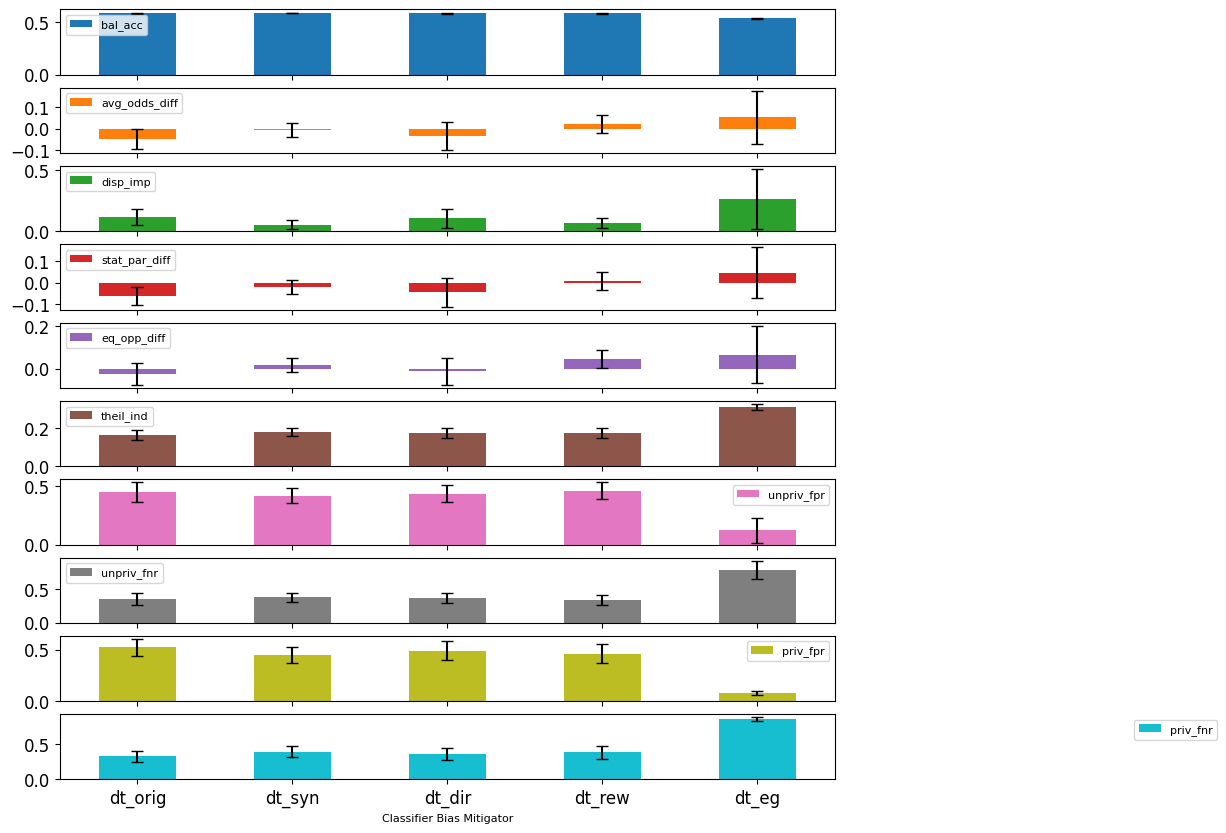

In [73]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [74]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [75]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

entire_dataset_mia_privacy_risk  \
Classifier MIA Attacks                                    
orig                                           0.518291   
syn                                            0.515748   
dir                                            0.524640   
rew                                            0.518031   
eg                                             0.511174   

                        entire_dataset_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.519704   
syn                                                      0.516428   
dir                                                      0.528835   
rew                                                      0.519035   
eg                                                       0.510634   

                        entire_dataset_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                              
orig                                                     0.542116   
syn                                                      0.536022   
dir                                                      0.549127   
rew                                                      0.541611   
eg                                                       0.519946   

                        subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.522190   
syn                                                         0.518921   
dir                                                         0.533153   
rew                                                         0.521112   
eg                                                          0.510543   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.544129   
syn                                                         0.537485   
dir                                                         0.553178   
rew                                                         0.544846   
eg                                                          0.521680   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.519646   
syn                                                         0.516918   
dir                                                         0.533770   
rew                                                         0.520046   
eg                                                          0.511596   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.542833  
syn                                                         0.537816  
dir                                                         0.554011  
rew                                                         0.543980  
eg                                                          0.520414

In [76]:
orig_mia_metrics

defaultdict(list,
            {'entire_dataset_mia_auc': [0.5288299000087674,
              0.5270715474333652,
              0.5261827911463755,
              0.5258746445193216,
              0.5228470001352099,
              0.5274713391142573,
              0.5232282528547015,
              0.5193056618452894,
              0.5214479155632405,
              0.5183796232942344,
              0.5196193938002428,
              0.5187477060188863,
              0.5287126762366279,
              0.5300273277993925,
              0.5296390433363829,
              0.5228726830274892,
              0.5213075771880495,
              0.518685478093771,
              0.5242987526664632,
              0.5288147907752596],
             'entire_dataset_mia_privacy_risk': [0.5213051651597888,
              0.5184406051383046,
              0.5207680601557605,
              0.5184853638886402,
              0.5152627338644705,
              0.5209470951571031,
              0.5204995076537463,
   

In [77]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'entire_dataset_label_0.0_mia_privacy_risk',
       'entire_dataset_label_1.0_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [78]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [79]:
df_groups

subpopulation_0.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.522190   
syn                                                         0.518921   
dir                                                         0.533153   
rew                                                         0.521112   
eg                                                          0.510543   

                        subpopulation_0.0_label_1.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.544129   
syn                                                         0.537485   
dir                                                         0.553178   
rew                                                         0.544846   
eg                                                          0.521680   

                        subpopulation_1.0_label_0.0_mia_privacy_risk  \
Classifier MIA Attacks                                                 
orig                                                        0.519646   
syn                                                         0.516918   
dir                                                         0.533770   
rew                                                         0.520046   
eg                                                          0.511596   

                        subpopulation_1.0_label_1.0_mia_privacy_risk  
Classifier MIA Attacks                                                
orig                                                        0.542833  
syn                                                         0.537816  
dir                                                         0.554011  
rew                                                         0.543980  
eg                                                          0.520414

<Axes: xlabel='Classifier MIA Attacks'>

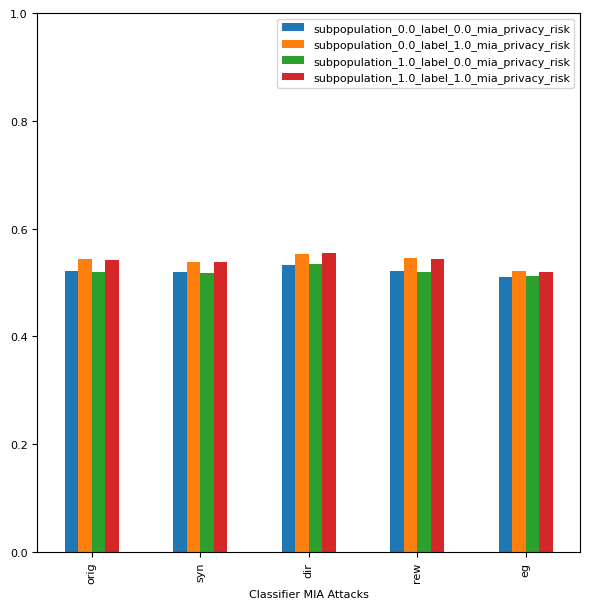

In [80]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [81]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                  orig       syn       dir       rew        eg
--------------------------------------------  --------  --------  --------  --------  --------
subpopulation_0.0_label_0.0_mia_privacy_risk  0.52219   0.518921  0.533153  0.521112  0.510543
subpopulation_0.0_label_1.0_mia_privacy_risk  0.544129  0.537485  0.553178  0.544846  0.52168
subpopulation_1.0_label_0.0_mia_privacy_risk  0.519646  0.516918  0.53377   0.520046  0.511596
subpopulation_1.0_label_1.0_mia_privacy_risk  0.542833  0.537816  0.554011  0.54398   0.520414


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.517117
1       orig               entire_dataset_mia_privacy_risk      0.517982
2       orig               entire_dataset_mia_privacy_risk      0.517550
3       orig               entire_dataset_mia_privacy_risk      0.521300
4       orig               entire_dataset_mia_privacy_risk      0.524954
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504434
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.505321
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.502599
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.503012
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.501923

[700 rows x 3 columns]

In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

Fairness                                           MIA  Privacy Risk
0       orig               entire_dataset_mia_privacy_risk      0.517117
1       orig               entire_dataset_mia_privacy_risk      0.517982
2       orig               entire_dataset_mia_privacy_risk      0.517550
3       orig               entire_dataset_mia_privacy_risk      0.521300
4       orig               entire_dataset_mia_privacy_risk      0.524954
..       ...                                           ...           ...
695       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.504434
696       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.505321
697       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.502599
698       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.503012
699       eg  subpopulation_1.0_label_1.0_mia_privacy_risk      0.501923

[500 rows x 3 columns]

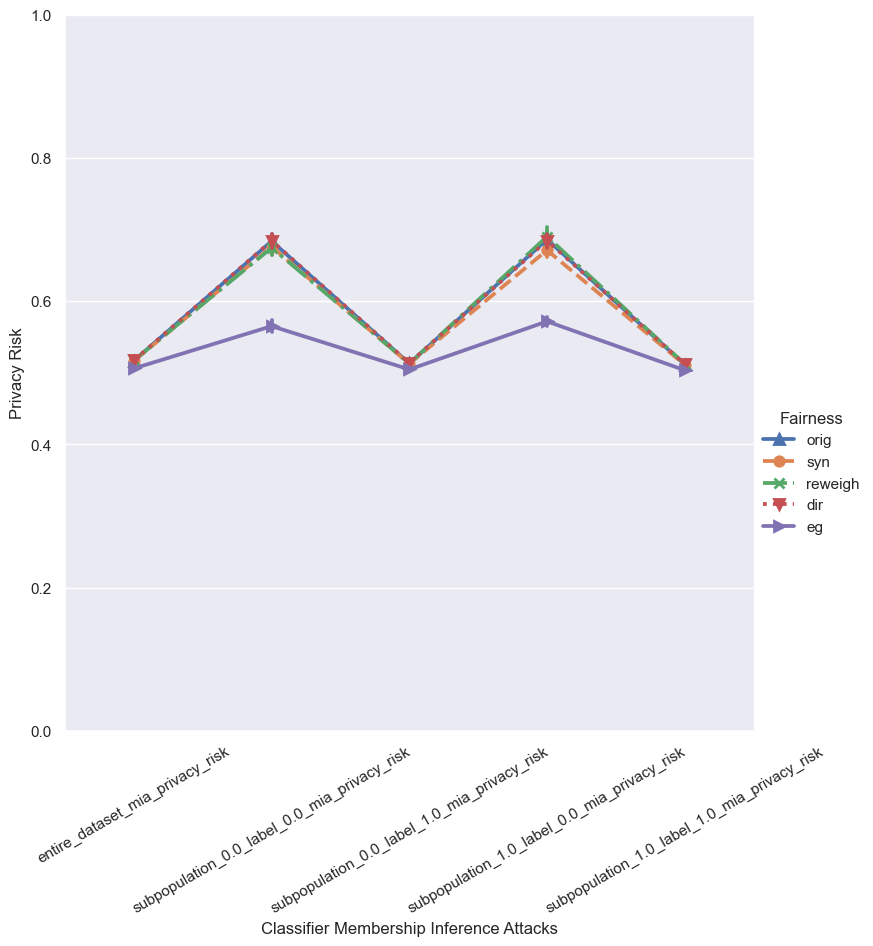

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr